In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import requests
import gzip
import os

In [2]:
# Function to download and extract KMNIST dataset
def download_kmnist():
    base_url = "http://codh.rois.ac.jp/kmnist/dataset/kmnist/"
    files = {
        "train_images": "train-images-idx3-ubyte.gz",
        "train_labels": "train-labels-idx1-ubyte.gz",
        "test_images": "t10k-images-idx3-ubyte.gz",
        "test_labels": "t10k-labels-idx1-ubyte.gz"
    }

    dataset = {}
    for key, file in files.items():
        path = os.path.join("./", file)
        if not os.path.exists(path):
            print(f"Downloading {file}...")
            with open(path, "wb") as f:
                f.write(requests.get(base_url + file).content)

        # Extract data
        with gzip.open(path, "rb") as f:
            if "images" in key:
                dataset[key] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
            else:
                dataset[key] = np.frombuffer(f.read(), np.uint8, offset=8)

    return (dataset["train_images"], dataset["train_labels"]), (dataset["test_images"], dataset["test_labels"])


In [3]:
# Load KMNIST dataset
(x_train, y_train), (x_val, y_val) = download_kmnist()

# Convert grayscale images to RGB
def preprocess_image(image, label):
    image = tf.image.grayscale_to_rgb(tf.expand_dims(image, axis=-1))  # تحويل إلى 3 قنوات
    image = tf.image.resize(image, (64, 64))  # تغيير الحجم إلى 64x64
    image = image / 255.0  # تطبيع القيم
    return image, tf.one_hot(label, 10)  # تحويل التصنيفات إلى One-hot

# Create dataset pipeline
batch_size = 32
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                 .map(preprocess_image)
                 .batch(batch_size)
                 .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset = (tf.data.Dataset.from_tensor_slices((x_val, y_val))
               .map(preprocess_image)
               .batch(batch_size)
               .prefetch(tf.data.experimental.AUTOTUNE))


In [4]:
# Load and prepare the ResNet50 model
base_model = keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(64, 64, 3)
)
base_model.trainable = False  # تجميد طبقات ResNet50
# Define the classification model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 تصنيفات لـ KMNIST
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [5]:
# Train Model
model.fit(train_dataset, validation_data=val_dataset, epochs=5)

# Fine-tuning: Unfreeze specific layers
base_model.trainable = True
for layer in base_model.layers[:100]:  # تجميد بعض الطبقات للحفاظ على الاستقرار
    layer.trainable = False

# Recompile and continue training
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(train_dataset, validation_data=val_dataset, epochs=3)


Epoch 1/5
1875/1875 [==============================] - 501s 266ms/step - loss: 1.1904 - accuracy: 0.6127 - val_loss: 1.0483 - val_accuracy: 0.6609
Epoch 2/5
1875/1875 [==============================] - 463s 247ms/step - loss: 0.7327 - accuracy: 0.7666 - val_loss: 0.8761 - val_accuracy: 0.7241
Epoch 3/5
1875/1875 [==============================] - 449s 239ms/step - loss: 0.6210 - accuracy: 0.8013 - val_loss: 0.8165 - val_accuracy: 0.7327
Epoch 4/5
1875/1875 [==============================] - 460s 245ms/step - loss: 0.5739 - accuracy: 0.8159 - val_loss: 0.7664 - val_accuracy: 0.7598
Epoch 5/5
1875/1875 [==============================] - 443s 236ms/step - loss: 0.5352 - accuracy: 0.8280 - val_loss: 0.7309 - val_accuracy: 0.7656
Epoch 1/3
1875/1875 [==============================] - 2113s 1s/step - loss: 0.8643 - accuracy: 0.8506 - val_loss: 0.5882 - val_accuracy: 0.8409
Epoch 2/3
1875/1875 [==============================] - 2143s 1s/step - loss: 0.2427 - accuracy: 0.9311 - val_loss: 0.644

In [6]:
# Evaluate Model
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

313/313 [==============================] - 62s 199ms/step - loss: 1.2710 - accuracy: 0.7108
Validation Accuracy: 71.08%


In [7]:
# Predict and generate confusion matrix
y_pred = model.predict(val_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for x, y in val_dataset])
y_true_classes = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

313/313 [==============================] - 62s 194ms/step


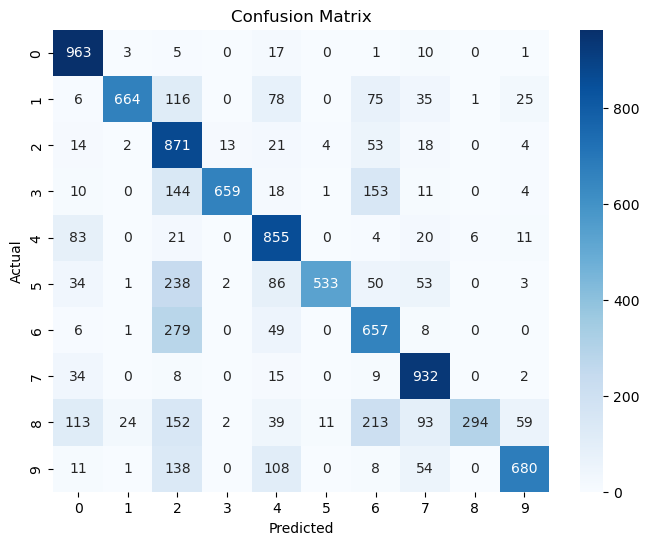

Fine-Tuning Complete!


In [8]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Fine-Tuning Complete!")